# Asset Comparison Toolbox I

## The idea

The idea of this script, is ***provide a set of practical tools*** which will allow the user to extract metrics which are useful to observe either indiviudal assets or compare pairs/groups of them. Going through the code step by step, the user will have access to some metrics which are practical when doing portfolio analysis, hedging, market strategies among other research.

**How are we going to do it?**

It will be focused 100% on the practical aspects, easy to use and with references to theoretical content when needed. The user will be able to use the script only by modifiying the assets on the cell dedicated to it.


This script pretends to be the first of a series where we provide a toolbox over the **first steps on asset comparison analysis** and other common topics what you can read on *What's comming next* section. 

## Index

    1. Data Processing
        1.1 User Inputs
        1.2 Data Retreival & Cleasing
        1.3 Data Upgrade
        1.4 Data Visualization
            1.4.1 Single Chart
            1.4.2 Full Sheet
            1.4.3 Scatter Matrix
    2. Correlation Coefficient & Regression Analisys
        2.1 Correlation Coefficient & Diversification
        2.2 Rolling Correlation
        2.3 Linear Regression, first approach
    3. Wrapping up
    4. Final considerations
    5. References
    6. What's comming next

## 1. Data Processing

In [1]:
import datetime as dt # Handle dates
import pandas as pd # Handle data structures
import pandas_datareader as pdr # Data Retreival
import matplotlib.pyplot as plt # Visualization
import numpy as np # Mathematical operations
import seaborn as sns # Plotting
import statsmodels.api as sm # Statistical Methods (not in depth o this script)

import warnings
warnings.filterwarnings("ignore")


sns.set_theme() # let's be stylish \(•_•)/
sns.set_style({'axes.grid' : True, "axes.facecolor": ".9"})

### 1.1 User Inputs

This will be, theoretically, the only cell where the user will have to modify the values in order to retreive the data and run the script according to the object of study. Just need to introduce the tickers to compare and the starting observation date.  

As explained before, the idea of this script is to be accesible to the many, therefore the data retreived is obtained from Yahoo!Finance via pandas_datareader. The tickers, will have to have the same format than in the web, as a example: 
***[S&P500 = ^GSPC]*** 

Check your tickers here: https://finance.yahoo.com/quote/%5EGSPC?p=^GSPC&.tsrc=fin-srch

In [2]:
# This is what you'll modify Tickers and date, should be all ;)

stocks = ['^GSPC','^VIX'] 
start_day = 1
start_month= 1
start_year = 2016

### 1.2 Data Retreival & Cleasing

Once we've decided which assets we're going to use for the study, we can start preparing our data for further process.

In [3]:
# Dates handling
start =dt.datetime(start_year, start_month, start_day)
now = dt.datetime.now()

# Data retreival, dataframe creation and cleasing
df_1 = pdr.get_data_yahoo(stocks, start, now)
df = df_1[[("Adj Close",s) for s in stocks]]
df.columns = df.columns.droplevel(level=0)


You can notice we're working with 2 Dataframes, **df_1** (raw) which will have all the information what Yahoo! Finance provide us in terms of Open - High - Low - Close & Adj Close - Volume, which is extremely useful for other researchs (Technical indicators, screener, etc). However, we want focus only on the closing prices (Adj Close) for this particular script, since is the metric we will use **for all the assets to be compared**. That's why we introduce a comprehension list to create a new dataframe named **df**

I'll print both df_1 and df for you to evaluate how's the dataframe we're looking at in case you want to use another source or API for the data retreival process using the same script without any further modification from this point.

In [4]:
df_1.tail() # Raw Dataframe coming from Yahoo! Finance

Attributes    Adj Close                   Close                    High  \
Symbols           ^GSPC       ^VIX        ^GSPC       ^VIX        ^GSPC   
Date                                                                      
2021-11-11  4649.270020  17.660000  4649.270020  17.660000  4664.549805   
2021-11-12  4682.850098  16.290001  4682.850098  16.290001  4688.470215   
2021-11-15  4682.799805  16.490000  4682.799805  16.490000  4697.419922   
2021-11-16  4700.899902  16.370001  4700.899902  16.370001  4714.950195   
2021-11-17  4688.669922  17.110001  4688.669922  17.110001  4701.500000   

Attributes                     Low                    Open             \
Symbols          ^VIX        ^GSPC       ^VIX        ^GSPC       ^VIX   
Date                                                                    
2021-11-11  18.389999  4648.310059  17.270000  4659.390137  18.340000   
2021-11-12  17.690001  4650.770020  16.150000  4655.240234  17.490000   
2021-11-15  17.459999  4672.859863  16.490000  4689.299805  17.030001   
2021-11-16  17.080000  4679.419922  16.030001  4679.419922  16.860001   
2021-11-17  17.190001  4684.410156  16.280001  4701.500000  16.360001   

Attributes      Volume       
Symbols          ^GSPC ^VIX  
Date                         
2021-11-11  2623140000    0  
2021-11-12  2865790000    0  
2021-11-15  2618980000    0  
2021-11-16  2838210000    0  
2021-11-17  3221250000    0

In [5]:
df.tail() # Simplified Dataframe we need.

Symbols,^GSPC,^VIX
Date,,
2021-11-11,4649.270020,17.660000
2021-11-12,4682.850098,16.290001
2021-11-15,4682.799805,16.490000
2021-11-16,4700.899902,16.370001
2021-11-17,4688.669922,17.110001


Once we've got the dataframe in the shape we'd like to have it, we can now easily visualize by df.plot

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

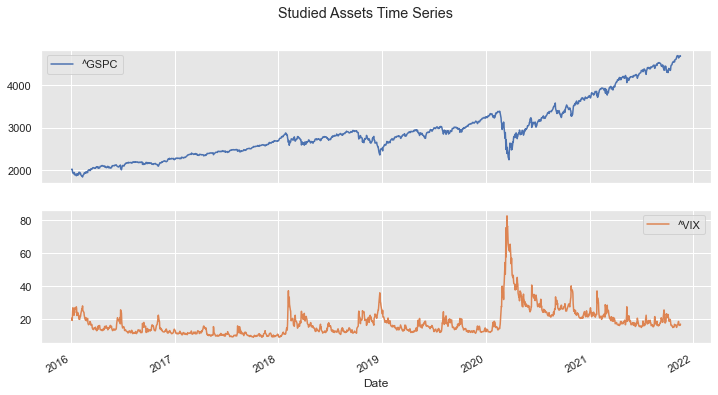

In [6]:
df.plot(subplots=True, grid=True, figsize=(12, 6), title='Studied Assets Time Series') 

### 1.3 Data Upgrade

When the final Dataframe has the format we want, we can start to use this information to start our study. Today, we're going to create subdataframes which derives from the updated one (df) and some static metrics. For example:

1. *rets* (DataFrame) - Logarithmic returns.
2. *month_vol & year_vol* (DataFrames) - Monthly (21d) and yearly (252d) rolling volatility.
3. *day_std* (Static) - Standard Deviation of log_return or Realized Volatility

For this script, I'll show the examples mentioned before, but I'm sure you'll have other ideas to develop, remember we're helping the ones on the first steps.

- One of the technical indicator libraries if you don't want to perform the calculations over the Dataframe values: https://technical-analysis-library-in-python.readthedocs.io/en/latest/

In [7]:
# Derived Dataframes
rets = np.log(df / df.shift(1))
year_vol = rets.rolling(window=252).std()
month_vol= rets.rolling(window=21).std()

# Remove NaN values if needed :)
rets.dropna(inplace=True)
year_vol.dropna(inplace=True)
month_vol.dropna(inplace=True)

# Example of static metrics

day_std_n = np.std(rets) # Numpy approach  rets[stocks[0]] to access single asset realized volatiliy
day_std_p = rets.std() # Pandas approach   "

In [8]:
print('=== Numpy approach ===')
print(day_std_n)
print('=== Pandas approach ===')
print(day_std_p)

=== Numpy approach ===
Symbols
^GSPC    0.011624
^VIX     0.082734
dtype: float64
=== Pandas approach ===
Symbols
^GSPC    0.011628
^VIX     0.082762
dtype: float64


You can notice by using Pandas or Numpy approach, the results might slightly vary, the reason behind that can be understood here:
https://stackoverflow.com/questions/24984178/different-std-in-pandas-vs-numpy, nothing major, small change on calculation process what could be transformed in case we wish to.

### 1.4 Data Visualization 

Same as we did before with the closing price, we could plot our derived dataframes in pairs to visually compare the metrics, either in two charts, overlapping, etc. That's totally up to you and your focus.
I'll share here another example but, I'll leave this plotting process for you and your creativity. 


Next I'll share a full sheet with all the metrics we're interested in today, like that you'll have both examples.

Have a look here to know more about plotting :):

- matplotlib: https://matplotlib.org/devdocs/plot_types/index.html
- seaborn: https://seaborn.pydata.org/index.html
- pandas.plot: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html



#### 1.4.1 Single visualization chart


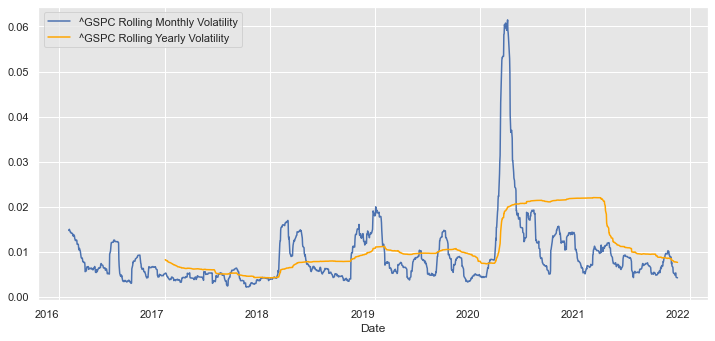

In [9]:
month_vol[stocks[0]].plot(subplots=True, grid=True, figsize=(12, 6), label =f'{stocks[0]} Rolling Monthly Volatility')
year_vol[stocks[0]].plot(subplots=True, grid=True, color ='orange', label =f'{stocks[0]} Rolling Yearly Volatility')

plt.legend()

##### 1.4.2 First Asset Full Visualization Sheet


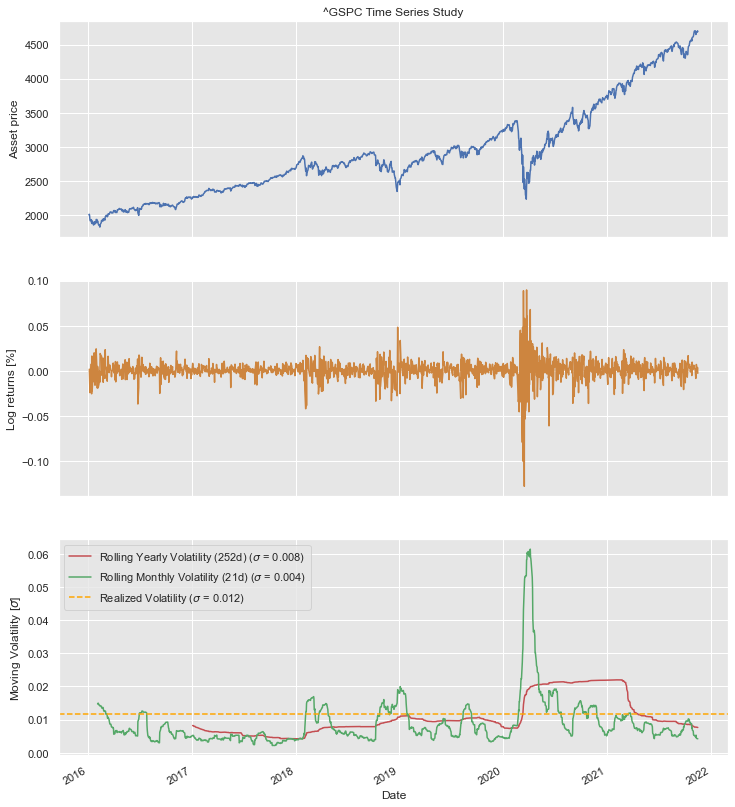

In [10]:
# FIRST ASSET VISUALIZATION

fig, ax = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

df[stocks[0]].plot(ax=ax[0])
ax[0].set(title=f'{stocks[0]} Time Series Study', ylabel='Asset price')

rets[stocks[0]].plot(ax=ax[1], color='peru')

ax[1].set(ylabel='Log returns [%]')
year_vol[stocks[0]].plot(ax=ax[2], color='r', label=f'Rolling Yearly Volatility (252d) ($\\sigma$ = {(year_vol[stocks[0]][-1]):.3f})')
month_vol[stocks[0]].plot(ax=ax[2], color='g', label=f'Rolling Monthly Volatility (21d) ($\\sigma$ = {(month_vol[stocks[0]][-1]):.3f})')

ax[2].set(ylabel='Moving Volatility [$\\sigma$]', xlabel='Date')
ax[2].axhline(rets[stocks[0]].std(), c='orange', linestyle=('--'), label=f'Realized Volatility ($\\sigma$ = {(rets[stocks[0]].std()):.3f})')

ax[2].legend()

##### Second Asset Full Visualization Sheet


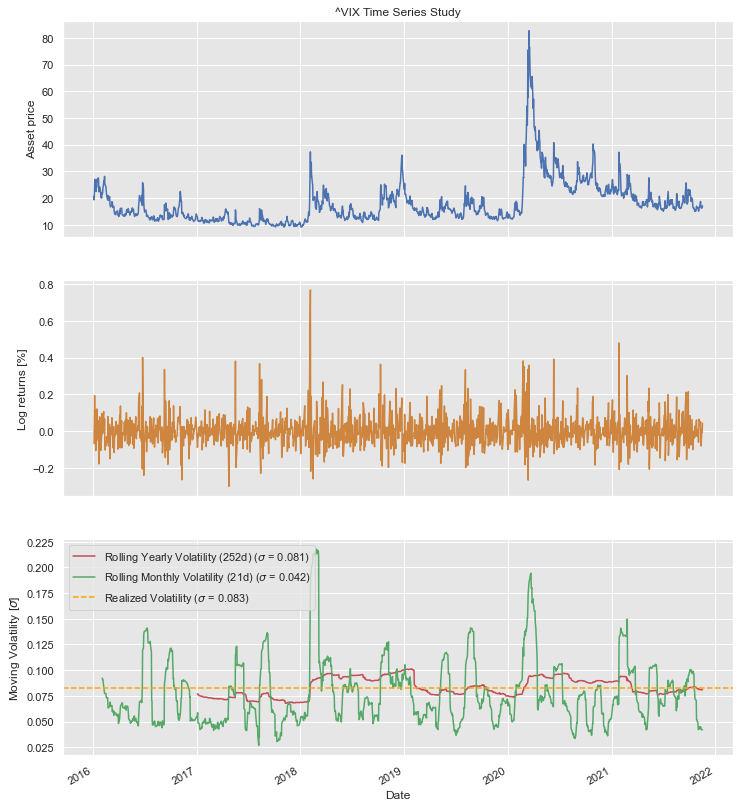

In [11]:
# SECOND ASSET VISUALIZATION

fig, ax = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

df[stocks[1]].plot(ax=ax[0])
ax[0].set(title=f'{stocks[1]} Time Series Study', ylabel='Asset price')

rets[stocks[1]].plot(ax=ax[1], color='peru')

ax[1].set(ylabel='Log returns [%]')
year_vol[stocks[1]].plot(ax=ax[2], color='r', label=f'Rolling Yearly Volatility (252d) ($\\sigma$ = {(year_vol[stocks[1]][-1]):.3f})')
month_vol[stocks[1]].plot(ax=ax[2], color='g', label=f'Rolling Monthly Volatility (21d) ($\\sigma$ = {(month_vol[stocks[1]][-1]):.3f})')

ax[2].set(ylabel='Moving Volatility [$\\sigma$]', xlabel='Date')
ax[2].axhline(rets[stocks[1]].std(), c='orange', linestyle=('--'), label=f'Realized Volatility ($\\sigma$ = {(rets[stocks[1]].std()):.3f})')

ax[2].legend()

As you can imagine at this point, you could chart whatever indicator you need on this sheet. Either coming from your updated dataframe as we did with our log-returns, or data received, created or manipulated from other source.


##### 1.4.3 Scatter Matrix


Finally, with the logarithmic returns dataframe *(rets)*, we could plot a scatter matrix. This function will plot the values of the dataframe series against each other and will allow us to go further in terms of comparision analysis. As well **it will give us a graphical view of the relations** beetween the variables compared.

On the diagonal, we will see an histogram (unless we decide to change it) of the logarithmic returns for the asset in the row. 

- Scatter matrix documentation: https://pandas.pydata.org/docs/reference/api/pandas.plotting.scatter_matrix.html


array([[<AxesSubplot:xlabel='^GSPC', ylabel='^GSPC'>,
        <AxesSubplot:xlabel='^VIX', ylabel='^GSPC'>],
       [<AxesSubplot:xlabel='^GSPC', ylabel='^VIX'>,
        <AxesSubplot:xlabel='^VIX', ylabel='^VIX'>]], dtype=object)

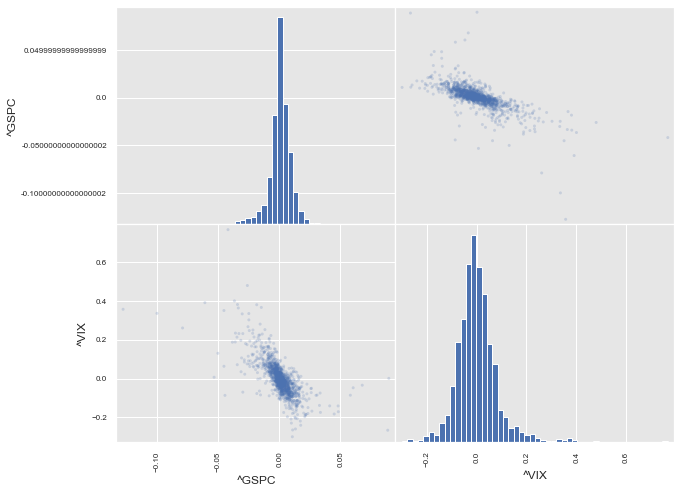

In [12]:
pd.plotting.scatter_matrix(rets, alpha=0.2, diagonal='hist', hist_kwds={'bins': 50}, figsize=(10, 8))

## 2. Correlation Coefficient & Regression Analisys

When analyzing a pair of assets, sometimes it's quite clear the existent correlation beetween both without any further step or visual analysis, a clear example (just to have a visual reference :)) could be a bond price chart and the yield chart with the negative correlation. But sometimes, this fact it's harder to observe, therefore we will need certain tools to try to quantify that measure.

### 2.1 Correlation Coefficient & Diversification

Diversification is achieved by combining assets whose returns moves, ideally, in opposite directions or, if they do it in the same direction, not with the same strength. In order to try to quantify this process, as a useful tool we've got the correlation coefficient.

This coefficent measures the strength of the relationship between two variables, which can be the prices of
two assets, or as in this example, their logarithmic returns.

- A **positive** correlation describes a relationship in which the **INCREASE** in the price the asset is associated with the **INCREASE** in the price of the other.

- A **negative** correlation is a relationship in which the **INCREASE** in the price of the asset is associated with the **DECREASE** in the price of the other.

- A **perfect correlation** is one in which a change in the price of the asset is **completely matched** by a change in the other's. If both increase together, they have a positive correlation perfect and its correlation coefficient is +1. If one decreases when the other increases, it is said that its correlation is perfect negative and its correlation coefficient is –1.

- When there are **no predictable common movements** in assets returns, it is said that the correlation is 0 or null.

Diversification and risk reduction is achieved by combining assets whose returns are not they match perfectly, or do not maintain a perfect positive correlation with each other.


- Correlation Coefficient documentation: https://www.investopedia.com/terms/c/correlationcoefficient.asp
- Correlation method used docs here: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html

In [13]:
rets.corr() # Correlation matrix from dataframe "rets". Note this step could store more than 2 symbols if needed.

Symbols,^GSPC,^VIX
Symbols,,
^GSPC,1.000000,-0.705498
^VIX,-0.705498,1.000000


In [14]:
corr_coeff = rets[stocks[0]].corr(rets[stocks[1]]) # To access the particular value we're interested
print(f'Correlation Coefficient for assets: {stocks[0]} vs {stocks[1]} is: {corr_coeff:.2f}')

Correlation Coefficient for assets: ^GSPC vs ^VIX is: -0.71


### 2.2 Rolling correlation

Once we've access to the static correlation coefficient, we could plot it together with the rolling correlation beetween the assets in order to visualize the point we're located at at the current observation point compared to this window (252d for the sample).

[Text(0.5, 1.0, 'Rolling Correlation ^GSPC vs. ^VIX ($\\rho$ = -0.71)'),
 Text(0, 0.5, 'Correlation Coefficent'),
 Text(0.5, 0, 'Period of time')]

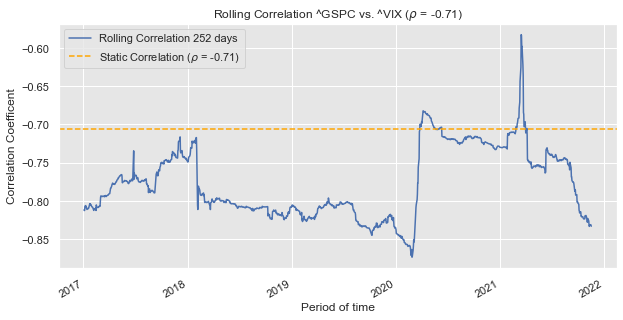

In [15]:
ax = rets[stocks[0]].rolling(window=252).corr(rets[stocks[1]]).plot(figsize=(10, 5), label='Rolling Correlation 252 days') 
ax.axhline(rets.corr().iloc[0, 1], c='orange',linestyle=('--'), label=f'Static Correlation ($\\rho$ = {corr_coeff:.2f})');
ax.legend()
ax.set(title=f'Rolling Correlation {stocks[0]} vs. {stocks[1]} ($\\rho$ = {corr_coeff:.2f})', ylabel='Correlation Coefficent', xlabel= 'Period of time')

Up to here, I hope all the tools explored make sense to you and will be useful in the future when observing certain assets. What we will se next?

### 2.3 Linear Regression, first approach

To finish this script, let's move one step further into the **Linear Regression Analysis**, at least to visualize it and we will leave it here for now. In the second part of this Comparison Toolbox, we will go deeper into the possibilities what this approach will show us, what information can we get and if it can be used in certain predcition models.


- Regression analysis: https://www.investopedia.com/terms/r/regression.asp
- General info Regression analysis: https://en.wikipedia.org/wiki/Linear_regression
- Statsmodels: https://www.statsmodels.org/stable/regression.html
- Seaborn Regplot: https://seaborn.pydata.org/generated/seaborn.regplot.html

[Text(0.5, 1.0, '^GSPC vs. ^VIX ($\\rho$ = -0.71)'),
 Text(0, 0.5, '^VIX log returns'),
 Text(0.5, 0, '^GSPC log returns')]

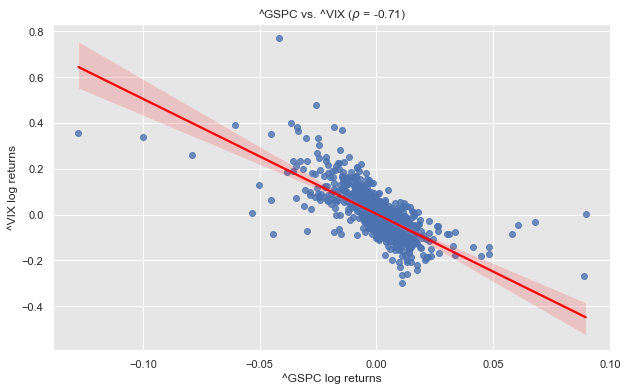

In [16]:
ax = sns.regplot(x=rets[stocks[0]], y=rets[stocks[1]], data=df, line_kws={'color': 'red'})
ax.figure.set_size_inches(10, 6)
ax.set(title=f'{stocks[0]} vs. {stocks[1]} ($\\rho$ = {corr_coeff:.2f})', ylabel=f'{stocks[1]} log returns', xlabel=f'{stocks[0]} log returns')

## 3. Wrapping up

As you've seen this essential approach will allow you to se how's the relation beetween the assets. We went through the classic combination  SP500 - VIX, but is now your turn to look for more. 

Remember this is another metric what might be useful on certain research. Maybe a highly correlated assets is what you're looking for, or maybe was the opposite.

- What about getting your potfolio returns? Are they highly correlated with your benchmark? Do you want to hedge it?
- Is your portfolio assets highly correlated beetween eachother?
- What Modern Portfolio Theory says about it?
- How USD index is correlated with commodities? and precious metals? What about currency pairs with stock benchmarks?
- Would you be able to prepare the correlation between log_returns of two baskets of assets? Let's start!

I leave you here to observe those questions.


## 4. Final Considerations

1. I try it to **keep it simple.**

    - In terms of coding, as generic and explicit as possible, with no complex structures (class or fuctions). The idea is for those on their *first steps*.
    - It will be some users who will need to adapt certain parts according to their own requirements (different data sources, ideas, etc. I did it in the way I thought would suit the most ;))
    - Using public libraries and not private API's for data retreival.
    

2. Focusing on the **applicability.**

    - We want to retreive information to optimize our analysis, help us or obtain conclusions.
    - We don't hundreds of charts, statistics or indicators to make a decission even more complex, **Analysis Paralysis**
    
    
3. Less frequency, more explain, more **practical**. Why?

    - There are thousands of professionals without knowledge of coding who find this as a barrier. Coding is as essential (or more) than Excel nowadays. Let's try to make easy to jump on it.
    - I prefer to develop every post with depth, focusing on practical tools rather than post low quality content.
    - Website is full non referenced content about financial markets. Let's try to be professionals, reference what we're talking about, etc, etc.



## 5. References used for this script

It's impossible to reference all the authors what influenced this script in one way or the other. However, some essential reads in order to perform this will be:

- Applied Financial Advice and Management 2nd Edition. *Kevin Rothwell, Chartered FCSI. Chartered Institute for Securities and Investments.*
- Mastering Python for Finance. *James Ma Weiming, Packt*
- Python for Finance. Mastering data-driven finance 2nd Edition. *Yves Hilpisch, O'Rilley.*
- Quantitative Finance. *Maria C. Mariani & Ionut Florescu. Wiley.*

On top of the web references written over the script and libraries documentations for the essential libraries such:

- Pandas
- Numpy
- Matplotlib
- Statsmodels
- Seaborn



## 6.What's coming next

According to the conversations I've got with most of you, I will be working on sharing:

- Portfolio analytics
- Risk metrics
- Derivatives Analytics
- Asset Analysis (as we had today :-))
- Backtesting
- Algorithmic Trading
- Screeners

How often?

- As soon as I manage to have time.
- As soon as I consider I've studied the topic enough to share useful tools :P.


To get in touch visit:
- Youtube: https://www.youtube.com/channel/UCP96sDHn704yOYJjvDOOOTQ
- Linkedin: https://www.linkedin.com/in/javiercg/
- Github: https://github.com/JavierCastilloGuillen
- Website: www.jcgmarkets.com/ (on development :S)
- Email: jcgmarkets@gmail.com

Feel free to get in touch :)